# Multiple Regression Practice with the Boston House Dataset

## Contents

#### 1. [Dataset Description](#s1)
#### 2. [Exploratory Data Analysis](#EDA)
#### 3. [Predictive Modeling](#PM)   
  - 3.0 [Model Metrics](#s30)
  - 3.1 [Linear Regression](#s31)
  - 3.2 [Ridge Regression](#s32)
  - 3.3 [Lasso Regression](#s33)
  - 3.4 [Decision Tree Regressor](#s34)
  - 3.5 [Random Forest Regressor](#s35)
  - 3.6 [XGBoost Regressor](#s36)
  - 3.7 [Support Vector Regressor](#s37)  

#### 4. [Model Evaluation](#s4)

----

<a id='s1'></a>
# 1. Dataset Description

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
from sklearn import datasets
boston = datasets.load_boston()
type(boston)

sklearn.utils.Bunch

The `boston` object works like a dictionary in that we can use the `keys` function.

In [4]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston.feature_names 

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [7]:
boston.data.shape

(506, 13)

In [8]:
boston_df  = pd.DataFrame(boston['data']) 
boston_df.columns = boston['feature_names'] # Set column indices as feature names
boston_df['PRICE'] = boston.target # Specify MEDV (PRICE) as the target variable.
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


----

<a id='EDA'></a>
## 2. Exploratory Data Analysis

Text(0, 0.5, 'Number of Houses')

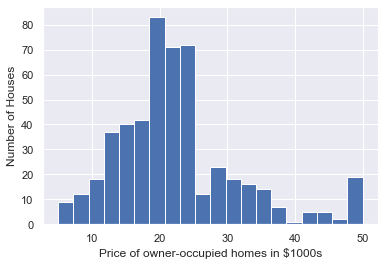

In [9]:
plt.hist(boston_df['PRICE'], bins=20)
plt.xlabel('Price of owner-occupied homes in $1000s')
plt.ylabel('Number of Houses')

To check if there are any missing values in the data, use the `isnull()` method.

In [10]:
def check_null_values(df):
    n_col = len(df.columns)
    null_counts = np.array(df.isnull().sum())
    if np.any(null_counts) == False:
        print("The DataFrame has no null values.")
    else:
        return df.isnull().sum()
        
check_null_values(boston_df)

The DataFrame has no null values.


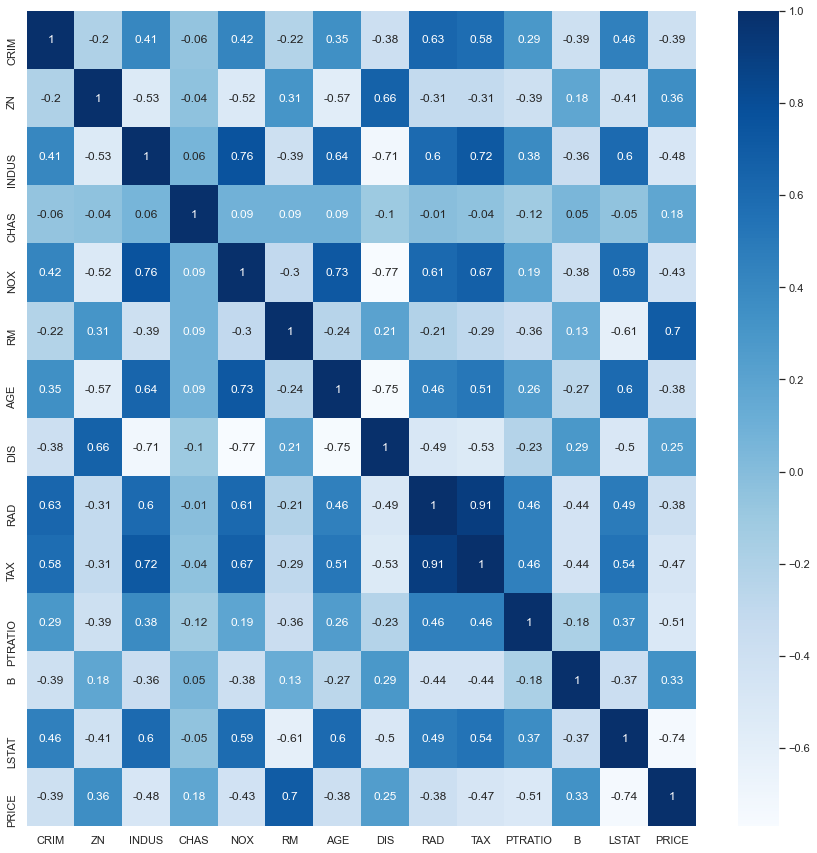

In [11]:
# Plotting the correlation between the features
corr = boston_df.corr().round(2)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='Blues')

From this plot, we can see that `RM` and `LSTAT` are very strongly correlated with `PRICE`. It may be helpful to use these features for my model.

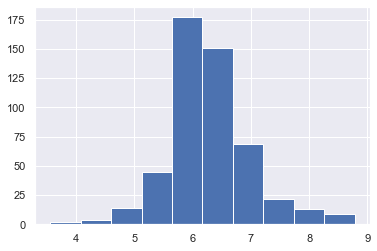

In [12]:
boston_df.RM.hist()

Box and Whisker plots make obvious which values are outliers and extreme values and which values are not. These plots represent more completely the range of values in the data by extending vertical lines to the largest and smallest values that are not outliers and extending short horizontal segments from these lines to make more apparent the values beyond which outliers begin.

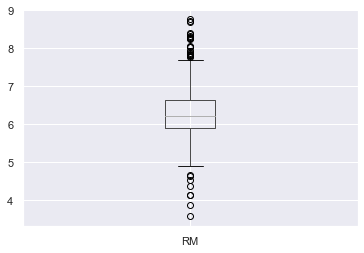

In [13]:
boston_df.boxplot(column = 'RM')

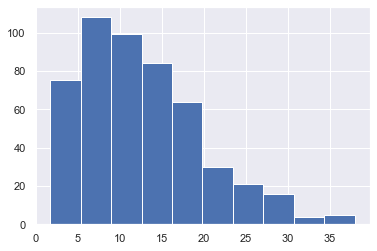

In [14]:
boston_df.LSTAT.hist()

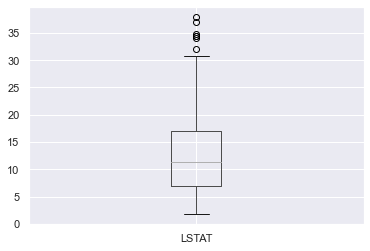

In [15]:
boston_df.boxplot(column = 'LSTAT')

In [16]:
# In case you prefer using np arrays, 
# boston_df.values is the array version of the dataframe
X = boston_df.values[: , :-1]
y = boston_df.values[: , -1].reshape(len(X[:,0]), 1)
X.shape, y.shape

((506, 13), (506, 1))

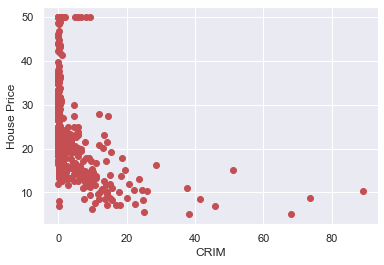

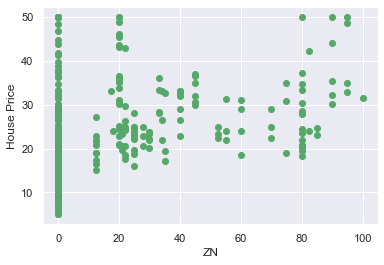

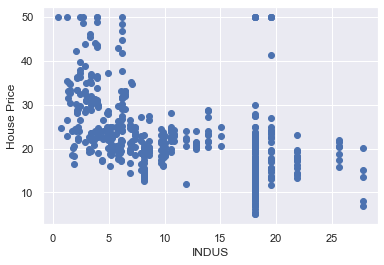

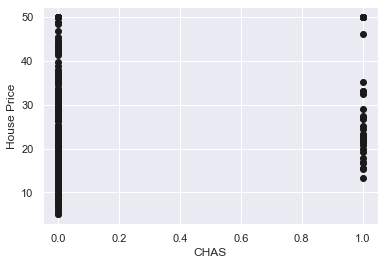

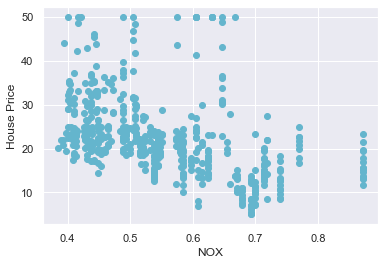

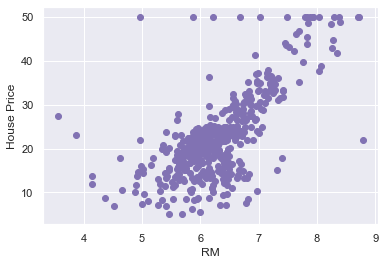

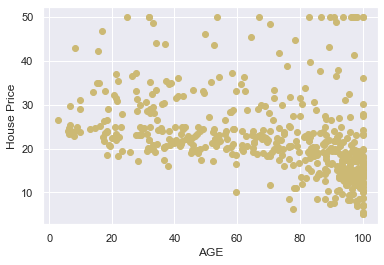

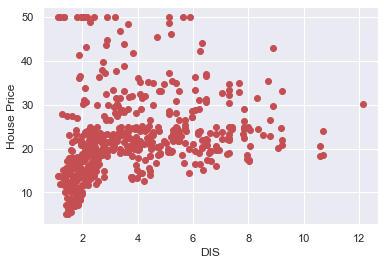

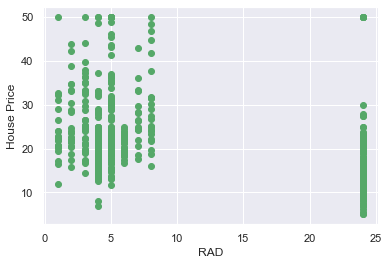

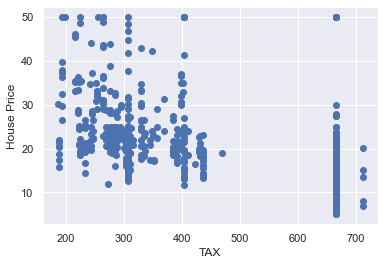

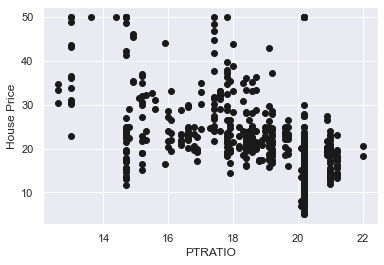

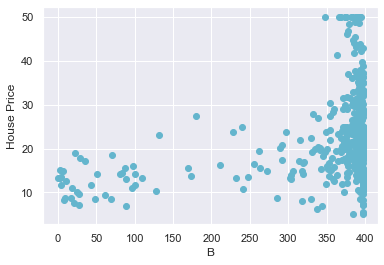

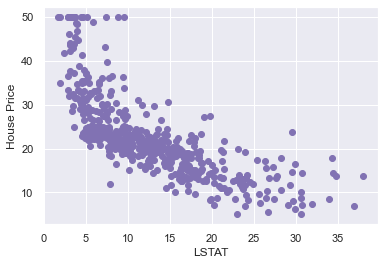

In [17]:
n_features = len(X[0])
colors = ['r', 'g', 'b', 'k', 'c', 'm', 'y']
color_wheel = colors + colors
for i in np.arange(n_features):
    x = X[:, i]
    plt.figure()
    plt.xlabel(boston.feature_names[i])
    plt.ylabel('House Price')
    plt.plot(x, y, str(color_wheel[i])+'o' )
    plt.show()

----

<a id='PM'></a>
# 3. Predictive Modeling


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, 
        test_size=0.3, random_state=7)

<a id='s30'></a>
## Model Metrics

Here, $n$ is `n_samples`, 
$\hat{y}$ is the vector of predicted values, 
and $y$ is the vector of observed values being predicted. 
Thus, $\hat{y}_i$ is the predicted value of the $i$th sample.

#### Mean absolute error (MAE):
$$ \text{MAE} = \frac{1}{n} \sum\limits_{i=1}^n |\hat{y}_i - y_i |$$

#### Mean squared error (MSE):
$$\text{MSE} = \frac{1}{n} \sum\limits_{i=1}^n (\hat{y}_i - y_i)^2 $$

#### Root mean square error/deviation (RMSE/RMSD):
$$ \text{RMSE}(\hat{y}) = \sqrt{\text{MSE}(\hat{y})} = \sqrt{ \frac{1}{n} \sum\limits_{i=1}^n (\hat{y}_i - y_i)^2 }$$ 

#### $R^2$ Score:

>In statistics, the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) or $R^2$, is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. - Wikipedia

From the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html): 
```
R^2 (coefficient of determination) regression score function. 

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get an R^2 score of 0.0.
```

In [36]:
from sklearn import metrics

def model_train(Sklearn_model, X_train=X_train, Y_train=Y_train):
    """Trains a scikit-learn model

    Args:
        Sklearn_model : input model that uses sklearn API
        X_train (array_like, shape (n_samples, n_features)): 
            Feature/ matrix. Defaults to X_train.
        Y_train (array_like, shape (n_samples, n_targets)): 
            Target matrix. Defaults to Y_train.

    Returns:
        model : a trained version of the input model
    """
    model = Sklearn_model
    model.fit(X_train, Y_train.ravel()) # trains model, i.e. finds parameters
    return model

def model_metrics(model, X_train=X_train, X_test=X_test, Y_test=Y_test):
    Y_pred = model.predict(X_test) # an array of predicted values
    MAE = metrics.mean_absolute_error(Y_test, Y_pred)
    MSE = metrics.mean_squared_error(Y_test, Y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
    R2 = metrics.r2_score(Y_test, Y_pred)
    metric_values = np.array([MAE, MSE, RMSE, R2])
    return metric_values, Y_pred

def print_metrics(metric_values):
    print("MAE", metric_values[0])
    print("MSE", metric_values[1])
    print("RMSE", metric_values[2])
    print("R-squared Score:", metric_values[3])
    
def graph_vs_predictions(Y_pred, Y_test=Y_test):
    plt.scatter(Y_test, Y_pred)
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

<a id='s31'></a>
## 3.1 Linear Regression Model

Model/Approximation:
$$ y = X\beta + \epsilon. $$
$y$ (array of shape (n_samples, 1)):  the target vector, <br>
$X$ (array of shape (n_samples, n_features + 1)): the design, or data,  matrix, <br>
$\beta$ (array of shape (n_features + 1, 1)): coefficient matrix, <br>
$\epsilon$ (array of shape (n_samples, 1)): the residual (or error).

Let $p$ denote the number of features, `n_features`, and $n$ denote the number of samples, `n_samples`. Then,
$$ 
y = X\beta + \epsilon \equiv 
\begin{pmatrix} 
    y_1 \\ \vdots \\ y_n
\end{pmatrix} = 
\begin{pmatrix}
    1 & x_{11} & \cdots & x_{1p} \\
    1 & x_{21} & \cdots & x_{2p} \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n1} & \cdots & x_{np}
\end{pmatrix}
\begin{pmatrix}
    \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p
\end{pmatrix} + 
\begin{pmatrix}
    \epsilon_1 \\ \vdots \\ \epsilon_n
\end{pmatrix}
$$

Notice, $\epsilon = y-X\beta$, which is why $(y-X\beta)^2 \equiv (y-\hat{y})^2$ is called a square residual.

In [19]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train, Y_train) # trains the model, i.e. finds the β coefficients 

LinearRegression()

``` 
intercept_ : float or array of shape (n_targets,)  
    Independent term in the linear model. Set to 0.0 if
    `fit_intercept = False`. 
```
In mathematical terms, the intercept is defined as the mean or expectation of $y$ when all of the features in the model are set to zero, so it's $\beta_0$ in the matrix formalism above. 

$$
\mathbb{E}(y) = \mathbb{E}(X\beta + \epsilon) = \mathbb{E}(X\beta).
$$
And when each feature value, $\beta_i$, is set equal to 0, $\mathbb{E}(y) = \beta_0$.

In [20]:
# Return the independent term, or intercept, of the linear model
print('β_0 : ', LR.intercept_)

β_0 :  [23.56213673]


In [21]:
LR.singular_

array([3.26946107e+03, 1.43575338e+03, 5.36008812e+02, 3.07647869e+02,
       1.17360510e+02, 9.76095363e+01, 7.28379831e+01, 5.80252113e+01,
       3.34777752e+01, 2.06076526e+01, 9.40959779e+00, 4.77312471e+00,
       1.01441301e+00])

In [22]:
# Return an array of the regression coefficients
LR.coef_

array([[-1.05682313e-01,  2.78511721e-02,  1.97751387e-02,
         2.74948915e+00, -1.55671652e+01,  5.31495793e+00,
        -1.07626811e-02, -1.31230457e+00,  2.55970709e-01,
        -1.06786333e-02, -9.61979065e-01,  1.18877016e-02,
        -3.85699081e-01]])

MAE 3.307638451069791
MSE 25.767879490836645
RMSE 5.076207195420282
R-squared Score: 0.6508417720329545


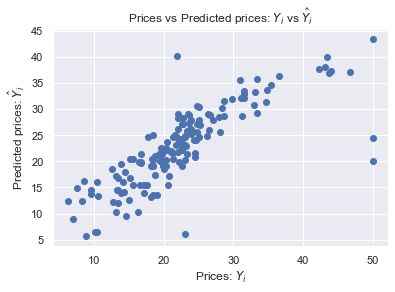

In [37]:
reg_0 = LR

metric_values = model_metrics(model_train(reg_0))[0] 
Y_pred = model_metrics(model_train(reg_0))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s32'></a>
## 3.2 Ridge Regression

[Wikipedia Summary](https://en.wikipedia.org/wiki/Tikhonov_regularization)
> Tikhonov regularization, named for Andrey Tikhonov, is a method of regularization of ill-posed problems. Also known as ridge regression, it is particularly useful to mitigate the problem of multicollinearity in linear regression, which commonly occurs in models with large numbers of parameters. In general, the method provides improved efficiency in parameter estimation problems in exchange for a tolerable amount of bias (see bias–variance tradeoff).


MAE 3.3150472344063284
MSE 26.27787009427617
RMSE 5.1261945041401
R-squared Score: 0.643931330859861


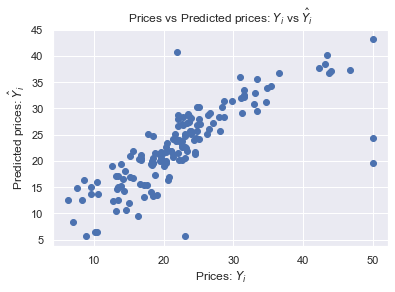

In [38]:
from sklearn.linear_model import Ridge
reg_1 = Ridge()

metric_values = model_metrics(model_train(reg_1))[0] 
Y_pred = model_metrics(model_train(reg_1))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s33'></a>
## 3.3 LASSO Regression

[Wikipedia Summary](https://en.wikipedia.org/wiki/Lasso_(statistics)):
> In statistics and machine learning, lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

MAE 3.3416852489576727
MSE 23.90558828559172
RMSE 4.889334135195888
R-squared Score: 0.6760760679870769


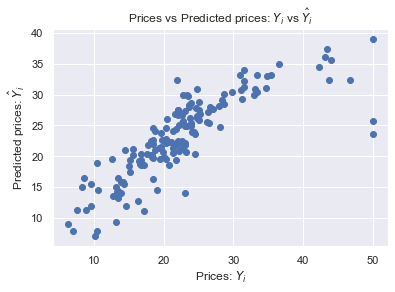

In [39]:
from sklearn.linear_model import Lasso
reg_2 = Lasso()

metric_values = model_metrics(model_train(reg_2))[0] 
Y_pred = model_metrics(model_train(reg_2))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s34'></a>
## 3.4 Decision Tree Regressor

This algorithm is a bit too complex for me to give a useful conceptual summary for. If you're not familiar with decision trees, I invite you to read [this post](https://gdcoder.com/decision-tree-regressor-explained-in-depth/), which explains the structure of  decision tree regressors very well.

MAE 2.943421052631579
MSE 19.86552631578947
RMSE 4.457075982725611
R-squared Score: 0.7308194502958476


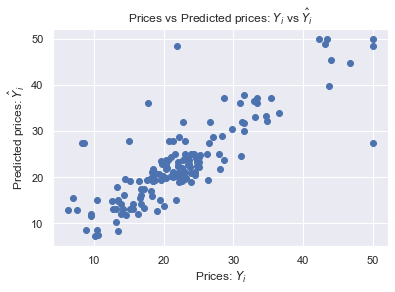

In [40]:
from sklearn.tree import DecisionTreeRegressor
reg_3 = DecisionTreeRegressor()

metric_values = model_metrics(model_train(reg_3))[0] 
Y_pred = model_metrics(model_train(reg_3))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s35'></a>
## 3.5 Random Forest Regressor

Algorithm explanation: [Link](https://towardsdatascience.com/random-forest-and-its-implementation-71824ced454f)

TL;DR: Random forest is an ensemble model and one of the most accuarate ML algorithms available. Random forests run efficiently on large datasets and are constructed from a multitude of decision trees.

MAE 2.338269736842104
MSE 12.650229927631575
RMSE 3.556716171924824
R-squared Score: 0.8285876854368929


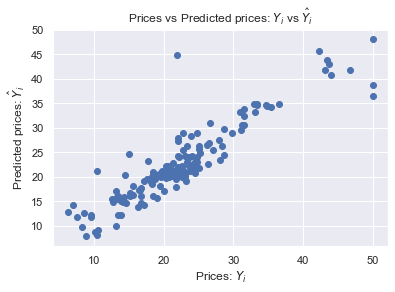

In [41]:
from sklearn.ensemble import RandomForestRegressor
reg_4 = RandomForestRegressor(random_state=3)

metric_values = model_metrics(model_train(reg_4))[0] 
Y_pred = model_metrics(model_train(reg_4))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s36'></a>
## 3.6 XGBoost Regressor 

XGBoost, short for e**X**treme **G**radient **B**oosting, is a gradient boosting algorithm authored by [Tianqi Chen](https://tqchen.com/).

#### Terminology Explanations:
- [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning)) :  an ensemble meta-algorithm for reducing bias and variance.
- [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) : A machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

#### Strengths of XGBoost
The algorithm's strengths were explained by Tianqi in a [quora post](https://www.quora.com/What-is-the-difference-between-the-R-gbm-gradient-boosting-machine-and-xgboost-extreme-gradient-boosting):
> Both xgboost and gbm follows the principle of gradient boosting.  There are however, the difference in modeling details. Specifically,  xgboost used a more regularized model formalization to control over-fitting, which gives it better performance.

> The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost. 



MAE 2.184927732066104
MSE 12.381583921473455
RMSE 3.518747493281303
R-squared Score: 0.8322278749019961


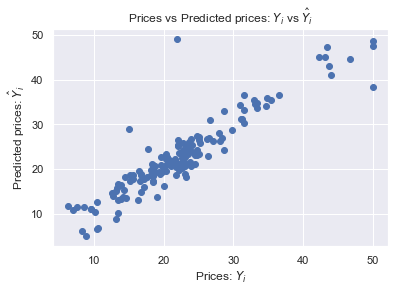

In [42]:
from xgboost import XGBRegressor
reg_5 = XGBRegressor()

metric_values = model_metrics(model_train(reg_5))[0] 
Y_pred = model_metrics(model_train(reg_5))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

<a id='s37'></a>
## 3.7 [Support Vector Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

> The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.  
The model produced by support vector classification depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.- [source](https://scikit-learn.org/stable/modules/svm.html#svm-regression)

MAE 3.282386852144568
MSE 31.58808740378112
RMSE 5.620328051260097
R-squared Score: 0.5719771731044268


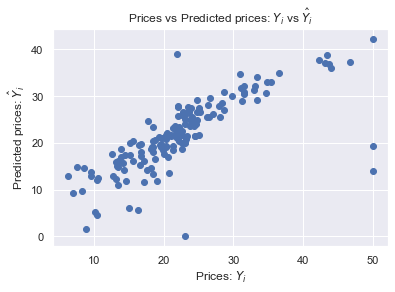

In [43]:
# import SVM Regressor
from sklearn import svm
reg_6 = svm.SVR(kernel='linear')

metric_values = model_metrics(model_train(reg_6))[0] 
Y_pred = model_metrics(model_train(reg_6))[1]

print_metrics(metric_values)
graph_vs_predictions(Y_pred)

---- 

<a id='s4'></a>
# 4. Model Evaluation

In [44]:
col_index = ['Linear', 'Ridge', 'Lasso', 'Decision Tree', 'Random Forest', 
          'XGB', 'SVR']
row_index = ['MAE', 'MSE', 'RMSE', 'R_sq']

col0 = model_metrics(model_train(reg_0))[0].reshape(4,1) 
col1 = model_metrics(model_train(reg_1))[0].reshape(4,1)
col2 = model_metrics(model_train(reg_2))[0].reshape(4,1)
col3 = model_metrics(model_train(reg_3))[0].reshape(4,1)
col4 = model_metrics(model_train(reg_4))[0].reshape(4,1)
col5 = model_metrics(model_train(reg_5))[0].reshape(4,1)
col6 = model_metrics(model_train(reg_6))[0].reshape(4,1)

In [45]:
unstructured_array = np.hstack((col0, col1, col2, col3, col4, col5, col6))
table = pd.DataFrame(unstructured_array)

col_index = pd.Series(col_index)
row_index = pd.Series(row_index)

table.columns = col_index
table.index = row_index
# Rank the models from best to worst
table.sort_values('R_sq', axis=1, ascending=False, inplace=True)

table.head()

,XGB,Random Forest,Lasso,Linear,Decision Tree,Ridge,SVR
MAE,2.184928,2.338270,3.341685,3.307638,3.304605,3.315047,3.282387
MSE,12.381584,12.650230,23.905588,25.767879,25.886776,26.277870,31.588087
RMSE,3.518747,3.556716,4.889334,5.076207,5.087905,5.126195,5.620328
R_sq,0.832228,0.828588,0.676076,0.650842,0.649231,0.643931,0.571977


In [46]:
# There are too many decimal places on the values in `table`.
# Truncate the floats to fit more nicely into 
# the matplotlib table generated by the `render_mpl_table` method.
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

table = np.array(table)

for i in range(table.shape[0]):
    for j in range(table.shape[1]):
        table[i, j] = truncate(table[i,j], 3)

table = pd.DataFrame(table)
table.columns = col_index
table.index = row_index
table

,Linear,Ridge,Lasso,Decision Tree,Random Forest,XGB,SVR
MAE,2.184,2.338,3.341,3.307,3.304,3.315,3.282
MSE,12.381,12.650,23.905,25.767,25.886,26.277,31.588
RMSE,3.518,3.556,4.889,5.076,5.087,5.126,5.620
R_sq,0.832,0.828,0.676,0.650,0.649,0.643,0.571


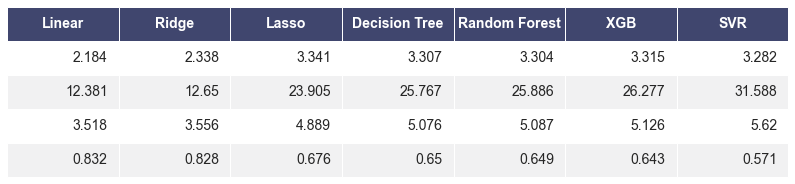

In [47]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], 
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = ((np.array(data.shape[::-1]) + np.array([0, 1])) 
                * np.array([col_width, row_height]))
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, 
                         bbox=bbox, 
                         colLabels=data.columns,
                         **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(table, header_columns=0, col_width=2.0)
plt.savefig('metrics_table.png')